<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/master/nb/HOD_HMC_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling HOD parameters by Hamiltonian Monte-Carlo

Authors:
 - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)
 - [@EiffL](https://github.com/EiffL) (Francois Lanusse)


This notebook demonstrate sampling HOD parameters using HMC over a stochastically sampled galaxy catalogs.




## Setup

Here we quickly install our dependencies, and download the reference halotools 
catalog from the Bolshoi simulation. This takes under a minute.

In [ ]:
!pip install --quiet -i https://test.pypi.org/simple/ halotools
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git

In [ ]:
!download_initial_halocat.py

In [1]:
%pylab inline
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

In [4]:
# A few hyper parameters
temperature=0.02
batch_size=1
max_sat=50
box_size = 128.

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

In [5]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
print("Size of halo catalog", len(halo_table))

# Convert table to tensors
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

Size of halo catalog 139905


In [6]:
# Here is how we define the same model in
@tf.function
def hod(halo_cat, 
        logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature)
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                       halo_cat['halo_y'],
                                       halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [7]:
gal_cat = hod(tf_halocat, 
              logMmin=12.02*tf.ones([batch_size]),
              sigma_logM=0.26*tf.ones([batch_size]), 
              logM0=11.38*tf.ones([batch_size]), 
              logM1=13.31*tf.ones([batch_size]), 
              alpha=1.06*tf.ones([batch_size]))

In [8]:
#batch compatable painter
@tf.function
def paint_galaxies(gal_cat, nc=128):
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  rho = cic_paint(tf.zeros((bs, nc, nc, nc)),sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)

  return rho

In [9]:
density = paint_galaxies(gal_cat)

In [10]:
density.shape

TensorShape([1, 128, 128, 128])

In [11]:
@tf.function
def sample(halo_cat, logMmin, sigma_logM, logM0, logM1, alpha):
    return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))

In [12]:
#check all variables for batch-ness
rho = sample(tf_halocat, 
             tf.convert_to_tensor([15.02,11.0]),
             tf.convert_to_tensor([0.26,0.22]), 
             tf.convert_to_tensor([10.0,11.]), 
             tf.convert_to_tensor([10.31,12.0]), 
             tf.convert_to_tensor([1.06,1.06]))

ValueError: in user code:

    <ipython-input-11-81ece4907db5>:3 sample  *
        return paint_galaxies(hod(halo_cat,logMmin, sigma_logM, logM0, logM1, alpha))
    <ipython-input-8-acd6d2d7901e>:23 paint_galaxies  *
        rho = cic_paint(rho, sample2, weights2)
    /local/home/flanusse/repo/DHOD/diffhod/utils.py:45 cic_paint  *
        kernel = tf.multiply(tf.expand_dims(weight, axis=-1), kernel)
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:6249 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3557 _create_op_internal
        ret = Operation(
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 6995250 and 3497625 for '{{node CiCPaint/Mul_2}} = Mul[T=DT_FLOAT](CiCPaint/ExpandDims_2, CiCPaint/mul_1)' with input shapes: [2,6995250,1], [2,3497625,8].


In [ ]:
imshow(np.array(rho[0]).sum(axis=0))
colorbar()
show()
imshow(np.array(rho[1]).sum(axis=0))
colorbar()
show()

In [14]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([box_size, box_size, box_size]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(halocat, logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06):
    k, pk = PS.pk_tf(sample(tf_halocat, logMmin=logMmin, sigma_logM=sigma_logM,
                            logM0=logM0, logM1=logM1, alpha=alpha))
    return k, pk

In [14]:
k, pk = get_pk(tf_halocat, 
             tf.convert_to_tensor([15.02,11.0]),
             tf.convert_to_tensor([0.26,0.22]), 
             tf.convert_to_tensor([10.0,11.]), 
             tf.convert_to_tensor([10.31,12.0]), 
             tf.convert_to_tensor([1.06,1.06]))

Instructions for updating:
Use fn_output_signature instead


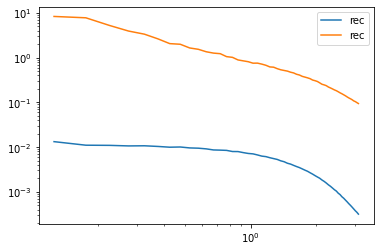

In [15]:
loglog(k,pk[0], label='rec')
loglog(k,pk[1], label='rec')
legend()

In [15]:
# Let's just compute a diagonal cov (takes a while...)
import time
start_time = time.time()
samps = []
for i in range(50):
  k, pk = get_pk(tf_halocat, 
                logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))
  samps.append(pk)
end_time = time.time()- start_time
print(end_time)

Instructions for updating:
Use fn_output_signature instead
36.11032223701477


In [17]:
samps = np.stack(samps, axis=0).reshape(100,-1)
diag_std = samps.std(axis=0)
mean = samps.mean(axis=0)

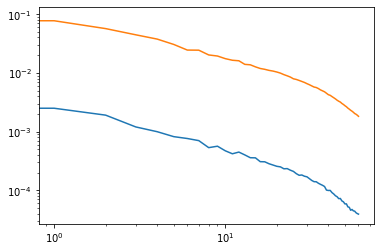

In [18]:
loglog(diag_std)
loglog(mean)

In [19]:
# This is not the right way to do this with edward, but...
import tensorflow_probability as tfp 
tfd = tfp.distributions

p = tf.tile(tf.expand_dims(fid_params,0), [batch_size, 1])

def log_prob_fn(params):
  k, pk = get_pk(tf_halocat, 
              logMmin=params[:,0],
              sigma_logM=params[:,1], 
              logM0=params[:,2], 
              logM1=params[:,3], 
              alpha=params[:,4])
  return tfd.MultivariateNormalDiag(loc=mean,scale_diag=diag_std).log_prob(pk)

In [20]:
log_prob_fn(p)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([458.09747, 456.85992], dtype=float32)>

In [21]:
num_burnin_steps = int(3e1) #oops....
num_chains = 2

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        num_leapfrog_steps=3,
        step_size=.03), #can play a lot with this number...
    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [22]:
#start spread out around some point
var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.02,0.01,0.1,0.01])*0.010

In [27]:
num_results = 100

# Initial state of the chain
init_state = tf.convert_to_tensor(np.ones([num_chains, 5], dtype=dtype)*fid_params+var,dtype=float32)

In [28]:
init_state

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[12.0197    ,  0.25997984, 11.379961  , 13.310083  ,  1.0600379 ],
       [12.02046   ,  0.25998247, 11.380019  , 13.309749  ,  1.059964  ]],
      dtype=float32)>

In [29]:
@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

    return samples,is_accepted#sample_mean, sample_stddev, is_accepted

In [30]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[2,8953920,8,3] and type int32 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mcmc_sample_chain/trace_scan/while/body/_442/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/body/_2118/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_3270/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/StatefulPartitionedCall/StatefulPartitionedCall/PartitionedCall/PartitionedCall_1/CiCPaint/Cast}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[mcmc_sample_chain/trace_scan/while/body/_442/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/body/_2118/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_3270/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/NFWProfile/NFWProfile_positions/sample/NFWProfile_VonMisesFisher/sample/normal/stateless_random_normal/StatelessRandomGetAlg/_345]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[2,8953920,8,3] and type int32 on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node mcmc_sample_chain/trace_scan/while/body/_442/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/body/_2118/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/body/_3270/mcmc_sample_chain/trace_scan/while/smart_for_loop/while/simple_step_size_adaptation___init__/_one_step/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/StatefulPartitionedCall/StatefulPartitionedCall/PartitionedCall/PartitionedCall_1/CiCPaint/Cast}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_run_chain_7724]

Function call stack:
run_chain -> run_chain
